In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix, 
                            classification_report, roc_curve, auc)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load and preprocess data
def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath)
    
    # Data cleaning
    data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce').fillna(0)
    data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0})
    
    # Feature engineering
    data['AvgChargePerTenure'] = data['TotalCharges'] / (data['tenure'] + 0.001)
    data['HasInternet'] = data['InternetService'].apply(lambda x: 0 if x == 'No' else 1)
    
    return data.drop('customerID', axis=1)

In [3]:
# Prepare modeling pipeline
def create_modeling_pipeline(model, preprocessor):
    return imbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model)
    ])

In [6]:
# Main execution
if __name__ == "__main__":
    # Load and prepare data
    data = load_and_preprocess_data('Customer_Churn.csv')
    X = data.drop('Churn', axis=1)
    y = data['Churn']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [8]:
# Define features
categorical_features = ['gender', 'SeniorCitizen','Partner', 'Dependents', 
                          'PhoneService', 'MultipleLines', 'InternetService',
                          'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                          'TechSupport', 'StreamingTV', 'StreamingMovies',
                          'Contract', 'PaperlessBilling', 'PaymentMethod']
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'AvgChargePerTenure']

In [9]:
    # Create preprocessing pipeline
preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [10]:
    # Define models and parameters
models = {
        'Random Forest': {
            'model': RandomForestClassifier(random_state=42),
            'params': {
                'classifier__n_estimators': [100, 200],
                'classifier__max_depth': [None, 10, 20],
                'classifier__min_samples_split': [2, 5]
            }
        },
        'Gradient Boosting': {
            'model': GradientBoostingClassifier(random_state=42),
            'params': {
                'classifier__n_estimators': [100, 200],
                'classifier__learning_rate': [0.01, 0.1],
                'classifier__max_depth': [3, 6]
            }
        }
    }

In [11]:
    # Train and evaluate models
best_models = {}
results = []

for name, config in models.items():
        print(f"\nTraining {name}...")
        
        # Create pipeline
        pipeline = create_modeling_pipeline(config['model'], preprocessor)
        
        # Grid search with single worker to avoid pickling issues
        grid_search = GridSearchCV(
            pipeline,
            config['params'],
            cv=5,
            scoring='roc_auc',
            n_jobs=1,
            verbose=1
        )
        grid_search.fit(X_train, y_train)


Training Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Training Gradient Boosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [12]:
        # Store best model (without SMOTE for serialization)
best_pipeline = Pipeline([
            ('preprocessor', grid_search.best_estimator_.named_steps['preprocessor']),
            ('classifier', grid_search.best_estimator_.named_steps['classifier'])
        ])
best_models[name] = best_pipeline

In [13]:
        # Evaluate
y_pred = best_pipeline.predict(X_test)
y_proba = best_pipeline.predict_proba(X_test)[:, 1]
        
        # Store metrics
results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_proba),
            'Best Params': grid_search.best_params_
        })


Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1552
           1       0.58      0.69      0.63       561

    accuracy                           0.78      2113
   macro avg       0.73      0.75      0.74      2113
weighted avg       0.80      0.78      0.79      2113



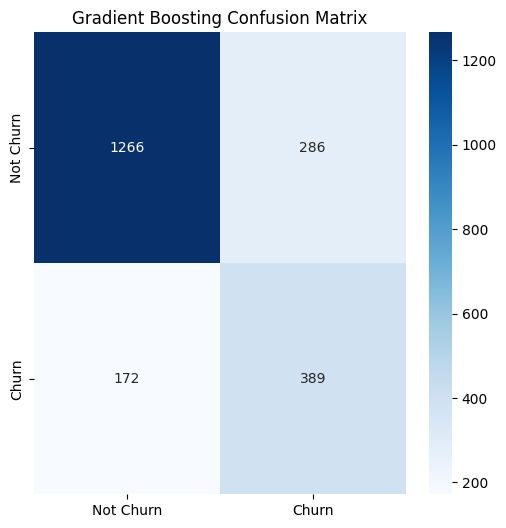

In [14]:
        # Generate reports
print(f"\n{name} Classification Report:")
print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), 
                   annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Not Churn', 'Churn'], 
                   yticklabels=['Not Churn', 'Churn'])
plt.title(f'{name} Confusion Matrix')
plt.show()

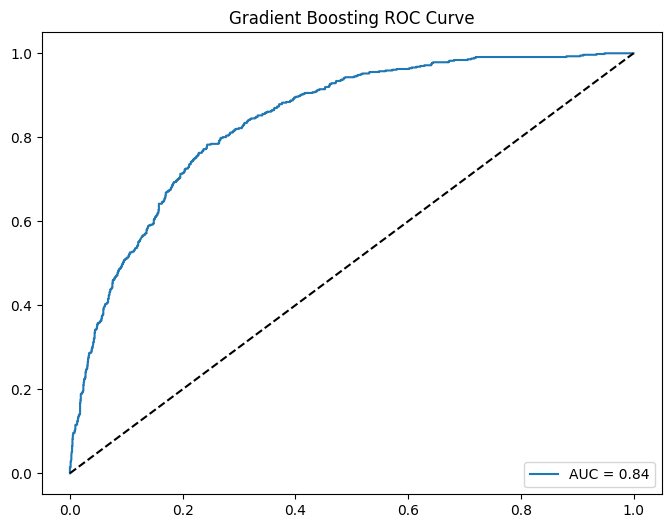

In [15]:
        # Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f'{name} ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [16]:
    # Results comparison
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df.sort_values('ROC AUC', ascending=False))
    
    # Select and save best model
best_model_name = results_df.loc[results_df['ROC AUC'].idxmax(), 'Model']
best_model = best_models[best_model_name]


Model Comparison:
               Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0  Gradient Boosting  0.783247   0.576296  0.693405   0.62945  0.840118   

                                         Best Params  
0  {'classifier__learning_rate': 0.1, 'classifier...  


In [17]:

    # Save model components separately to avoid pickling issues
model_artifacts = {
        'preprocessor': best_model.named_steps['preprocessor'],
        'model': best_model.named_steps['classifier'],
        'feature_names': {
            'numerical': numerical_features,
            'categorical': categorical_features
        }
    }
joblib.dump(model_artifacts, 'best_churn_model.pkl')
print("\nModel saved successfully as 'best_churn_model.pkl'")




Model saved successfully as 'best_churn_model.pkl'


In [19]:
# Example prediction function
def predict_churn(customer_data, model_path='best_churn_model.pkl'):
        """Predict churn for new customer data"""
        artifacts = joblib.load(model_path)
        
        # Create pipeline from saved components
        pipeline = Pipeline([
            ('preprocessor', artifacts['preprocessor']),
            ('classifier', artifacts['model'])
        ])
        
        # Prepare input data
        input_df = pd.DataFrame([customer_data])
        input_df = load_and_preprocess_data(input_df) if isinstance(input_df, str) else input_df
        
        # Make prediction
        proba = pipeline.predict_proba(input_df)[0][1]
        return {
            'churn_probability': proba,
            'prediction': 'Yes' if proba >= 0.5 else 'No'
        }

    # Example usage:
    # sample_customer = { ... }  # Your customer data here
    # print(predict_churn(sample_customer))